<a href="https://colab.research.google.com/github/Nikichel/colarization-NN/blob/main/colarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import struct
import os

from array import array
from os import path
from PIL import Image
import numpy as np

import torch
import torchvision

from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt

from torchvision.transforms import v2
from torch import nn

from tqdm import tqdm
import random

from skimage.color import rgb2lab, lab2rgb
from io import BytesIO
from google.colab import files

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
upl = files.upload()
names = list(upl.keys())

img = Image.open(BytesIO(upl[names[0]]))

Saving cats400.jpg to cats400.jpg


In [ ]:
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=False),
    ]
)

def processed_img(img):
  image = img.resize((256,256), Image.BILINEAR)
  image = np.array(image, dtype=np.float32)
  size = image.shape


  lab = rgb2lab(image/255)
  X, Y = lab[:, :, 0], lab[: ,:,1:]


  Y /= 128  #a and b : {-1; 1}

  X = transform(X)
  Y = transform(Y)

  X = X.unsqueeze(0)
  Y = Y.unsqueeze(0)

  return X, Y, size

In [ ]:
L, AB, size = processed_img(img)

print(L.shape)
print(f"min:{L.min()}, max:{L.max()}")
print(AB.shape)
print(f"min:{AB.min()}, max:{AB.max()}")
print(size)


torch.Size([1, 1, 256, 256])
min:1.7824974060058594, max:98.34857177734375
torch.Size([1, 2, 256, 256])
min:-0.36752888560295105, max:0.7135083675384521
(256, 256, 3)


(256, 256)


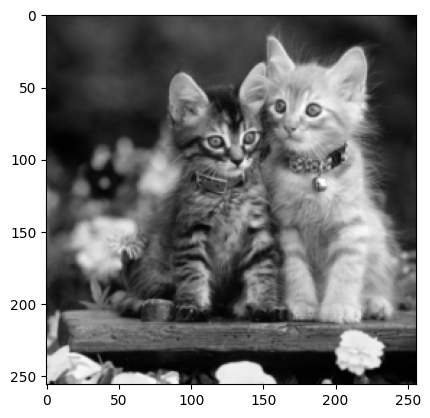

In [ ]:
l_np = L.squeeze().cpu().detach().numpy()

print(l_np.shape)

plt.imshow(l_np, cmap='gray')

(-0.5, 255.5, 255.5, -0.5)

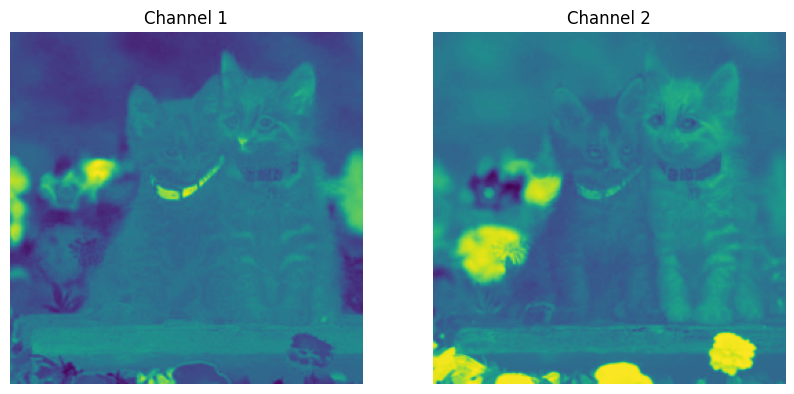

In [ ]:
Y_show = AB.squeeze().cpu().detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(Y_show[0])
axs[0].set_title('Channel 1')
axs[0].axis('off')

axs[1].imshow(Y_show[1])
axs[1].set_title('Channel 2')
axs[1].axis('off')

In [ ]:
class Colorizer(nn.Module):
    def __init__(self):
        super(Colorizer, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 2, 3, padding=1),
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='nearest')
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = Colorizer()

loss_model = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# Цикл обучения
for i in range (70):
  # Тренировка модели
  model.train()

  pred = model(L)
  loss = loss_model(pred, AB)
  print(loss.item())
   #обратный проход
  opt.zero_grad()
  loss.backward()
    #шаг оптимизации
  opt.step()

  print(f'Epoch {i+1}/50, Loss: {loss.item()}')




0.02347777783870697
Epoch 1/50, Loss: 0.02347777783870697
0.022598832845687866
Epoch 2/50, Loss: 0.022598832845687866
0.02160673402249813
Epoch 3/50, Loss: 0.02160673402249813
0.019984791055321693
Epoch 4/50, Loss: 0.019984791055321693
0.018073366954922676
Epoch 5/50, Loss: 0.018073366954922676
0.018623463809490204
Epoch 6/50, Loss: 0.018623463809490204
0.017271684482693672
Epoch 7/50, Loss: 0.017271684482693672
0.016855623573064804
Epoch 8/50, Loss: 0.016855623573064804
0.017023079097270966
Epoch 9/50, Loss: 0.017023079097270966
0.016989126801490784
Epoch 10/50, Loss: 0.016989126801490784
0.016585683450102806
Epoch 11/50, Loss: 0.016585683450102806
0.016060592606663704
Epoch 12/50, Loss: 0.016060592606663704
0.016034970059990883
Epoch 13/50, Loss: 0.016034970059990883
0.015842119231820107
Epoch 14/50, Loss: 0.015842119231820107
0.015262449160218239
Epoch 15/50, Loss: 0.015262449160218239
0.014951554127037525
Epoch 16/50, Loss: 0.014951554127037525
0.014575056731700897
Epoch 17/50, Los

In [ ]:
upl = files.upload()
names = list(upl.keys())

img = Image.open(BytesIO(upl[names[0]]))
X, Y, size = processed_img(img)


Saving tmb_308630_864157.jpg to tmb_308630_864157.jpg


torch.Size([2, 256, 256])
torch.Size([3, 256, 256])
(256, 256, 3)


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 31 pixels
  return func(*args, **kwargs)


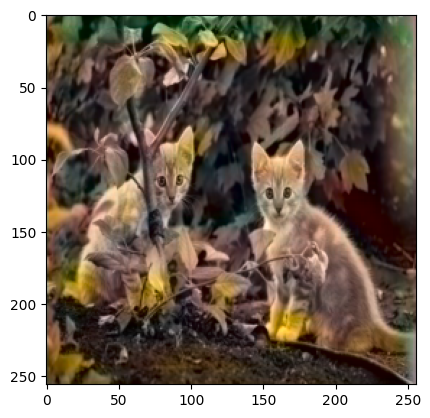

In [ ]:
model.eval()
output = model(X)
output = output.squeeze()

print(output.shape)

ab = output.clamp_(-1, 1)

cur = torch.zeros (3, 256, 256)

cur[0,:,:] = X[:,:,:]
cur[1:,:,:] = ab[:,:,:]*128

print(cur.shape)

cur  = cur.detach().numpy()

# Транспонирование и перенос каналов в конец
cur  = cur .transpose((1, 2, 0))
print(cur.shape)

plt.imshow(lab2rgb(cur))